## CIFAR10 Image Classification Production Deployment

![cifar10](demo.png)

We show an image classifier (CIFAR10) with associated outlier and drift detectors using a Pipeline.

 * The model is a tensorflow [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) image classfier 
 * The outlier detector is created from the [CIFAR10 VAE Outlier example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/od_vae_cifar10.html).
 * The drift detector is created from the [CIFAR10 KS Drift example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_ks_cifar10.html)
 
### Model Training (optional for notebook)

To run local training run the [training notebook](train.ipynb).

In [1]:
import requests
import json
from typing import Dict, List
import numpy as np
import os
import tensorflow as tf
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.datasets import fetch_cifar10c
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()

2023-02-03 18:04:20.979821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-03 18:04:20.979834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
outliers = []
for idx in range(0,X_train.shape[0]):
    X_mask, mask = apply_mask(X_train[idx].reshape(1, 32, 32, 3),
                                  mask_size=(12,12),
                                  n_masks=1,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))
    outliers.append(X_mask)
X_outliers = np.vstack(outliers)
X_outliers.shape

(50000, 32, 32, 3)

In [4]:
corruption = ['gaussian_noise']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

In [5]:
reqJson = json.loads('{"inputs":[{"name":"input_1","data":[],"datatype":"FP32","shape":[]}]}')
url = "http://0.0.0.0:9000/v2/models/model/infer"

In [6]:
def infer(resourceName: str, batchSz: int, requestType: str):
    if requestType == "outlier":
        rows = X_outliers[0:0+batchSz]
    elif requestType == "drift":
        rows = X_corr[0:0+batchSz]
    else:
        rows = X_train[0:0+batchSz]
    for i in range(batchSz):
        show(rows[i])
    reqJson["inputs"][0]["data"] = rows.flatten().tolist()
    reqJson["inputs"][0]["shape"] = [batchSz, 32, 32, 3]
    headers = {"Content-Type": "application/json", "seldon-model":resourceName}
    response_raw = requests.post(url, json=reqJson, headers=headers)
    print(response_raw)
    print(response_raw.json())
    

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis("off")
    plt.show()


### Pipeline

In [7]:
!cat ../../models/cifar10.yaml
!echo "---"
!cat ../../models/cifar10-outlier-detect.yaml
!echo "---"
!cat ../../models/cifar10-drift-detect.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: cifar10
spec:
  storageUri: "gs://seldon-models/triton/tf_cifar10"
  requirements:
  - tensorflow
---
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: cifar10-outlier
spec:
  storageUri: "gs://seldon-models/scv2/examples/cifar10/outlier-detector"
  requirements:
    - mlserver
    - alibi-detect
---
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: cifar10-drift
spec:
  storageUri: "gs://seldon-models/scv2/examples/cifar10/drift-detector"
  requirements:
    - mlserver
    - alibi-detect


In [8]:
!seldon model load -f ../../models/cifar10.yaml
!seldon model load -f ../../models/cifar10-outlier-detect.yaml
!seldon model load -f ../../models/cifar10-drift-detect.yaml

{}
{}
{}


In [9]:
!seldon model status cifar10 -w ModelAvailable | jq .
!seldon model status cifar10-outlier -w ModelAvailable | jq .
!seldon model status cifar10-drift -w ModelAvailable | jq .

{}
{}
{}


In [10]:
!cat ../../pipelines/cifar10.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Pipeline
metadata:
  name: cifar10-production
spec:
  steps:
    - name: cifar10
    - name: cifar10-outlier
    - name: cifar10-drift
      batch:
        size: 20
  output:
    steps:
    - cifar10
    - cifar10-outlier.outputs.is_outlier


In [11]:
!seldon pipeline load -f ../../pipelines/cifar10.yaml

{}


In [12]:
!seldon pipeline status cifar10-production -w PipelineReady| jq -M .

{
  "pipelineName": "cifar10-production",
  "versions": [
    {
      "pipeline": {
        "name": "cifar10-production",
        "uid": "cfekpeoq4n3c73fctno0",
        "version": 1,
        "steps": [
          {
            "name": "cifar10"
          },
          {
            "name": "cifar10-drift",
            "batch": {
              "size": 20
            }
          },
          {
            "name": "cifar10-outlier"
          }
        ],
        "output": {
          "steps": [
            "cifar10.outputs",
            "cifar10-outlier.outputs.is_outlier"
          ]
        },
        "kubernetesMeta": {}
      },
      "state": {
        "pipelineVersion": 1,
        "status": "PipelineReady",
        "reason": "created pipeline",
        "lastChangeTimestamp": "2023-02-03T18:04:44.043515049Z",
        "modelsReady": true
      }
    }
  ]
}


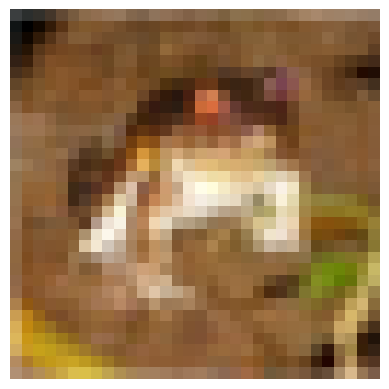

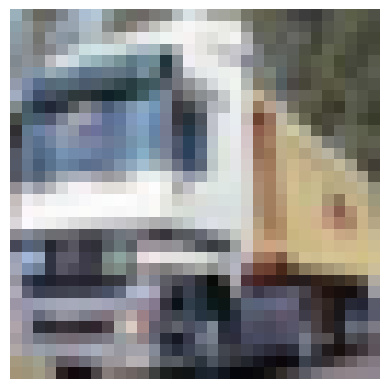

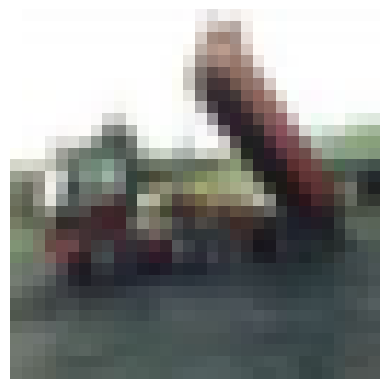

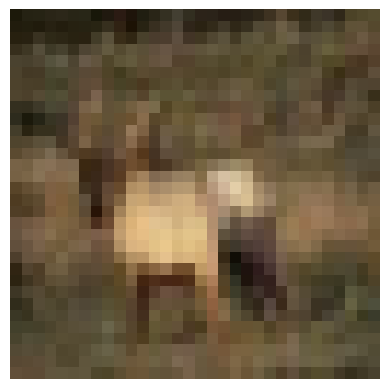

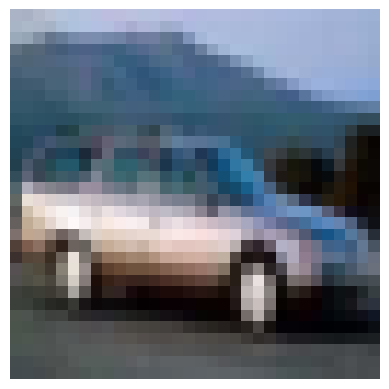

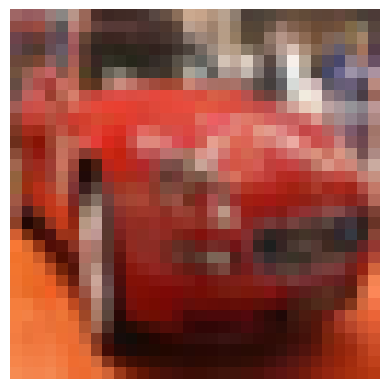

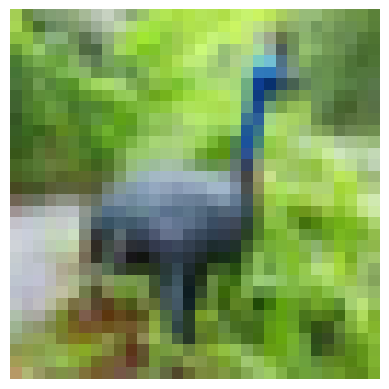

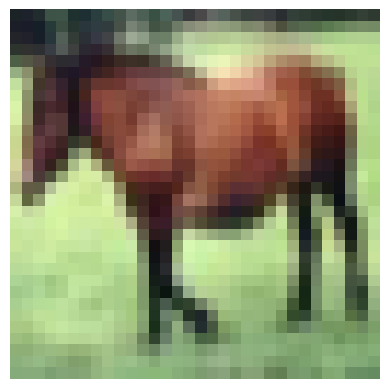

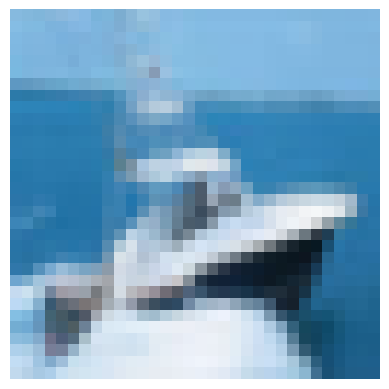

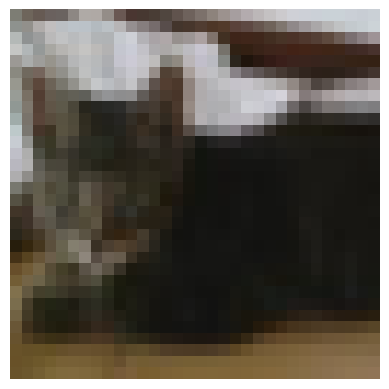

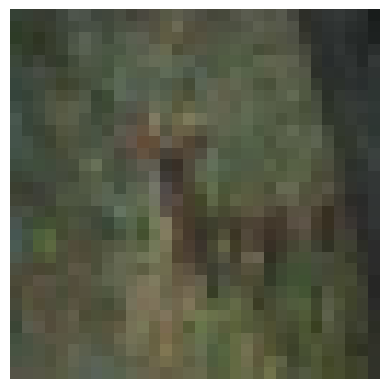

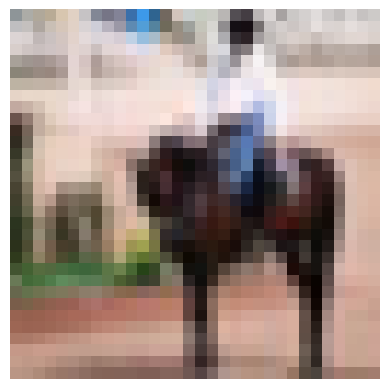

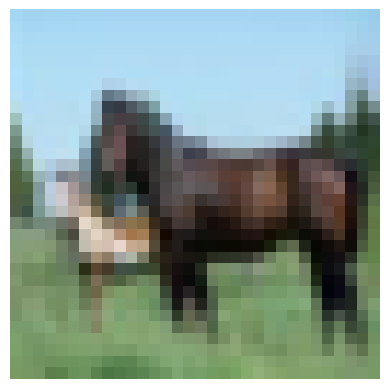

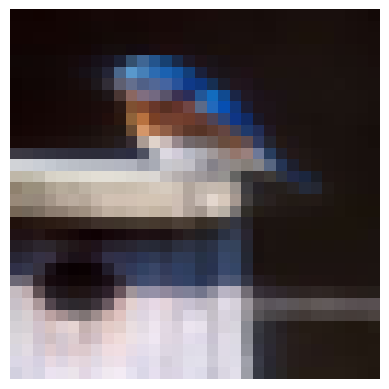

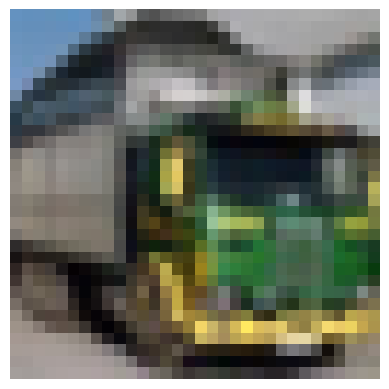

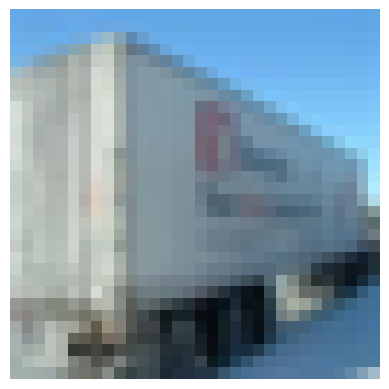

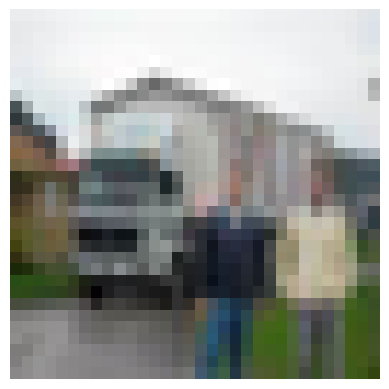

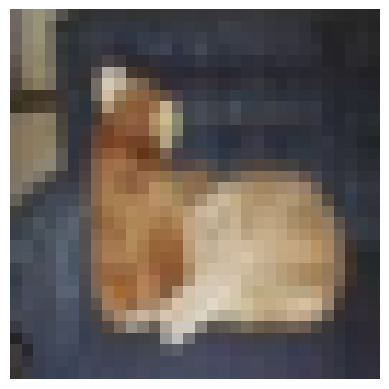

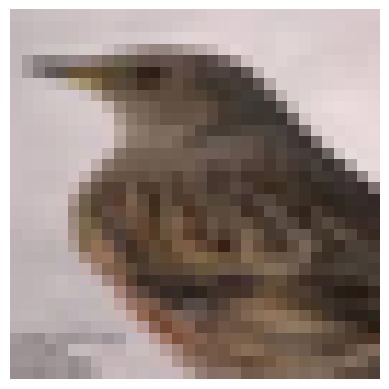

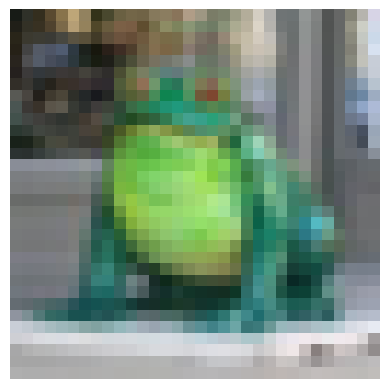

<Response [200]>
{'model_name': '', 'outputs': [{'data': [1.45001495e-08, 1.2525752e-09, 1.6298458e-07, 0.11529388, 1.7431412e-07, 6.1856604e-06, 0.8846994, 6.0739285e-09, 7.437921e-08, 4.7317337e-09, 1.26449e-06, 4.8814868e-09, 1.5153439e-09, 8.490656e-09, 5.5131194e-10, 1.1617216e-09, 5.7729294e-10, 2.8839776e-07, 0.0006149016, 0.99938357, 0.888746, 2.5331951e-06, 0.00012967695, 0.10531583, 2.4284174e-05, 6.3332986e-06, 0.0016261435, 1.13079e-05, 0.0013286703, 0.0028091935, 2.0993439e-06, 3.680449e-08, 0.0013269952, 2.1766558e-05, 0.99841356, 0.00015300694, 6.9472035e-06, 1.3277059e-05, 6.1860555e-05, 3.4072806e-07, 1.1205097e-05, 0.99997175, 1.9948227e-07, 6.9880834e-08, 3.3387135e-08, 5.2603138e-08, 3.0352305e-07, 4.3738982e-08, 5.3243946e-07, 1.5870584e-05, 0.0006525102, 0.013322109, 1.480307e-06, 0.9766325, 4.9847167e-05, 0.00058075984, 0.008405659, 5.2234273e-06, 0.00023390084, 0.000116047224, 1.6682397e-06, 5.7737526e-10, 0.9975605, 6.45564e-05, 0.002371972, 1.0392675e-07, 9.74

In [13]:
infer("cifar10-production.pipeline",20, "normal")

In [14]:
!seldon pipeline inspect cifar10-production.cifar10-drift.outputs.is_drift

seldon.default.model.cifar10-drift.outputs	cfekpg8fh5ss739vr5tg	{"name":"is_drift","datatype":"INT64","shape":["1","1"],"contents":{"int64Contents":["0"]}}


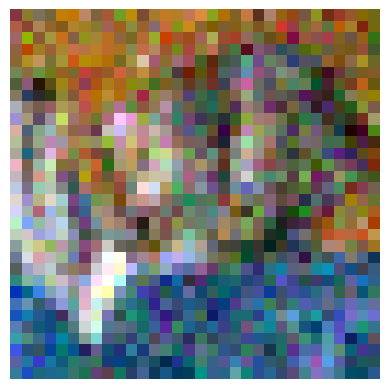

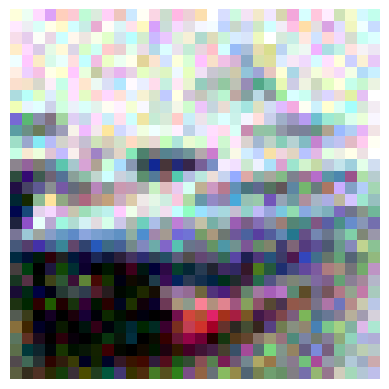

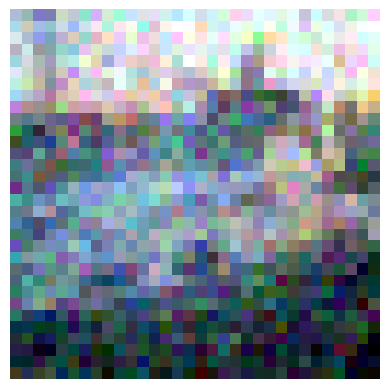

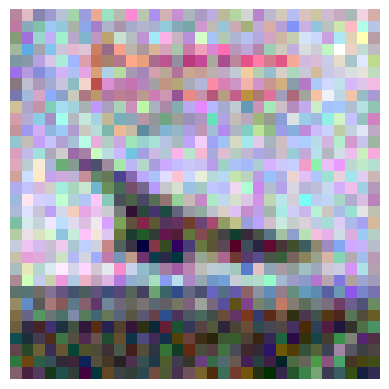

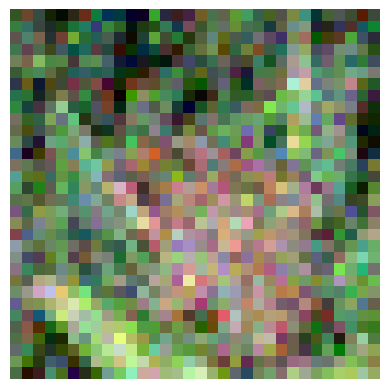

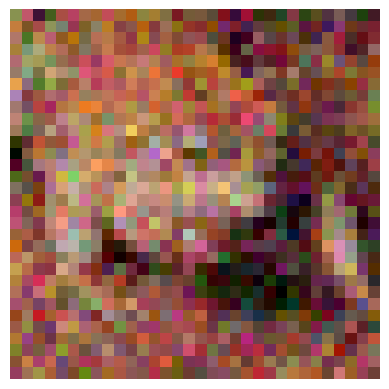

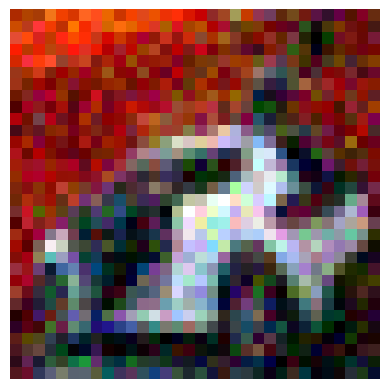

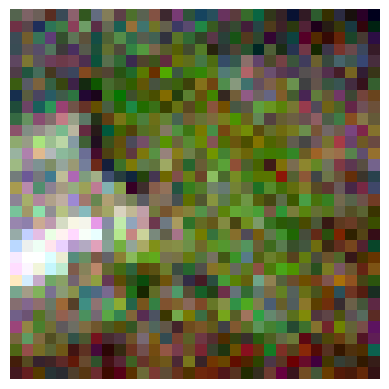

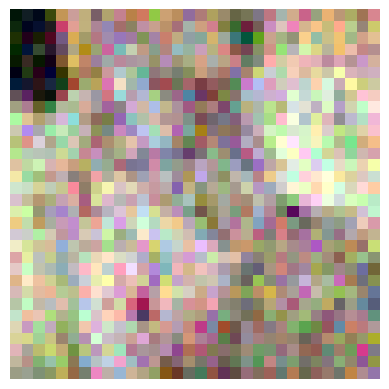

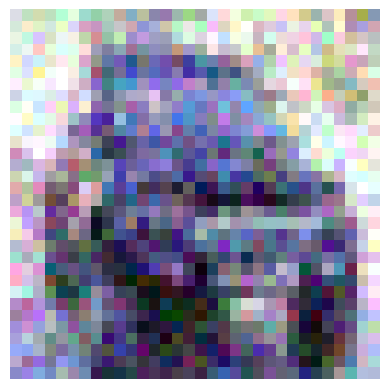

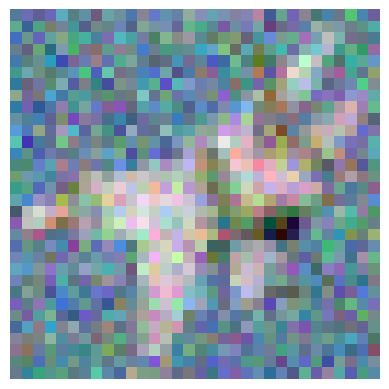

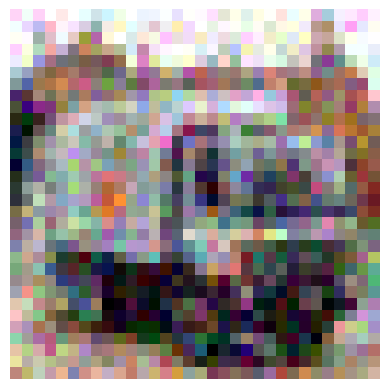

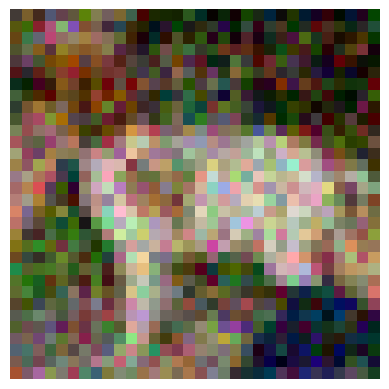

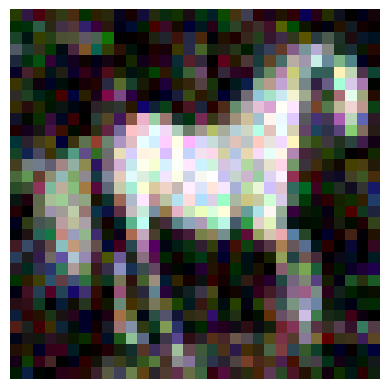

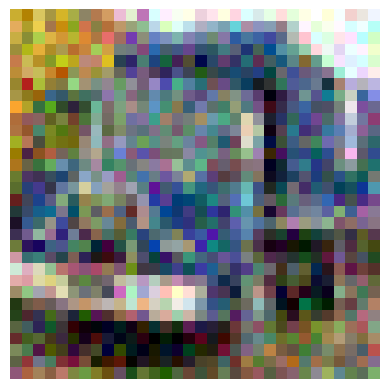

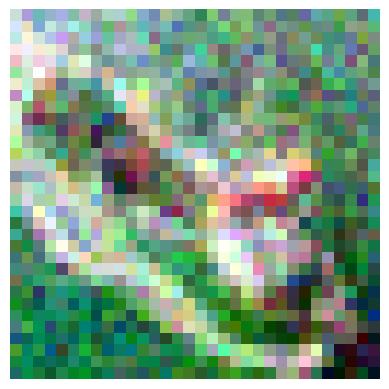

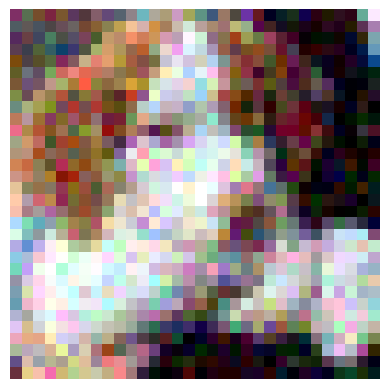

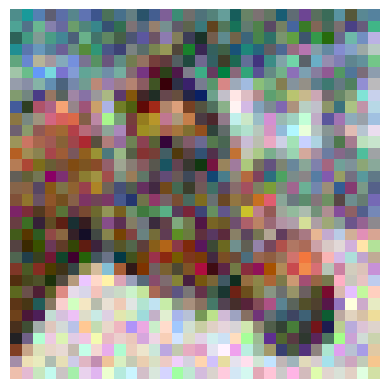

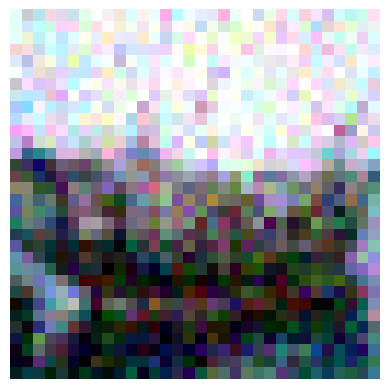

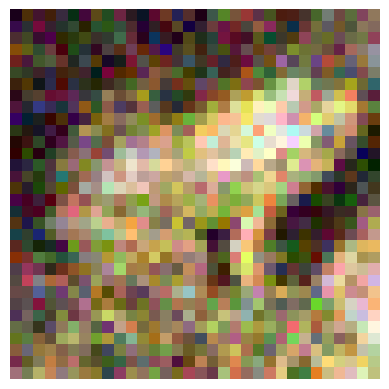

<Response [200]>
{'model_name': '', 'outputs': [{'data': [1.6211208e-09, 4.0089754e-10, 0.0004583845, 0.932375, 4.1514153e-07, 8.396962e-06, 0.0671577, 9.0561736e-10, 2.3456077e-09, 1.2709157e-10, 0.0013329197, 8.311341e-06, 0.92835414, 0.004928552, 0.006884555, 0.00035946266, 0.00044588794, 1.1627396e-05, 0.057670258, 4.246253e-06, 6.174382e-06, 4.222969e-06, 0.009117617, 0.6239796, 3.5445457e-05, 0.00017580668, 1.2707611e-05, 8.81675e-07, 0.3666669, 6.16647e-07, 4.3034826e-05, 1.1155572e-06, 0.9716082, 0.0036068736, 0.00029337086, 0.000113066584, 0.00059629563, 1.5656573e-05, 0.02372147, 9.690217e-07, 1.378388e-06, 9.712984e-08, 0.1105977, 0.8890721, 4.8204645e-05, 3.7169924e-05, 0.0002424484, 2.9864822e-07, 4.902796e-07, 1.5026151e-08, 5.9766074e-07, 1.7625035e-07, 0.27393404, 0.7257613, 6.0214446e-05, 0.00011405888, 0.00012225499, 1.4559914e-06, 5.9373265e-06, 3.2447105e-08, 2.6817952e-08, 1.9999208e-08, 0.00013637744, 0.9135113, 2.4218636e-07, 3.201824e-07, 0.086351745, 4.2980517e

In [15]:
infer("cifar10-production.pipeline",20, "drift")

In [16]:
!seldon pipeline inspect cifar10-production.cifar10-drift.outputs.is_drift

seldon.default.model.cifar10-drift.outputs	cfekpiofh5ss739vr5u0	{"name":"is_drift","datatype":"INT64","shape":["1","1"],"contents":{"int64Contents":["1"]}}


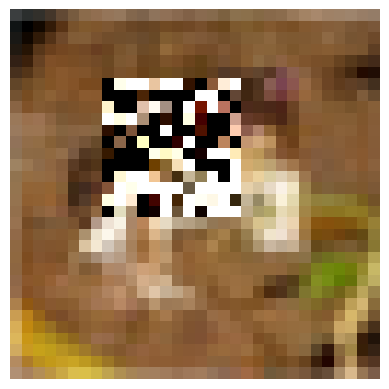

<Response [200]>
{'model_name': '', 'outputs': [{'data': [2.544475e-06, 2.7632382e-07, 1.9947075e-07, 0.0002308716, 2.7517972e-08, 9.416619e-06, 0.9997557, 6.393948e-08, 3.56468e-07, 4.794506e-07], 'name': 'fc10', 'shape': [1, 10], 'datatype': 'FP32'}, {'data': [1], 'name': 'is_outlier', 'shape': [1, 1], 'datatype': 'INT64'}]}


In [17]:
infer("cifar10-production.pipeline",1, "outlier")

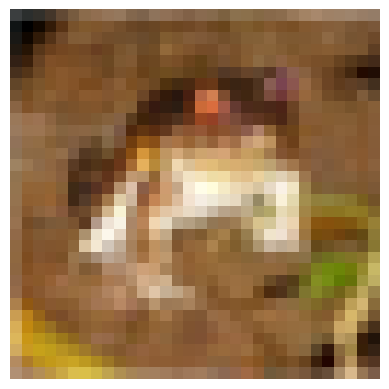

<Response [200]>
{'model_name': '', 'outputs': [{'data': [1.45001495e-08, 1.2525752e-09, 1.6298458e-07, 0.11529388, 1.7431412e-07, 6.1856604e-06, 0.8846994, 6.0739285e-09, 7.43792e-08, 4.7317337e-09], 'name': 'fc10', 'shape': [1, 10], 'datatype': 'FP32'}, {'data': [0], 'name': 'is_outlier', 'shape': [1, 1], 'datatype': 'INT64'}]}


In [18]:
infer("cifar10-production.pipeline",1, "ok")

Use the seldon CLI to look at the outputs from the CIFAR10 model. It will decode the Triton binary outputs for us.

In [19]:
!seldon pipeline inspect cifar10-production.cifar10.outputs

seldon.default.model.cifar10.outputs	cfekplofh5ss739vr5v0	{"modelName":"cifar10_1","modelVersion":"1","outputs":[{"name":"fc10","datatype":"FP32","shape":["1","10"],"contents":{"fp32Contents":[1.45001495e-8,1.2525752e-9,1.6298458e-7,0.11529388,1.7431412e-7,0.0000061856604,0.8846994,6.0739285e-9,7.43792e-8,4.7317337e-9]}}]}


In [20]:
!seldon pipeline unload cifar10-production

{}


In [21]:
!seldon model unload cifar10
!seldon model unload cifar10-outlier
!seldon model unload cifar10-drift

{}
{}
{}
